In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import re
import matplotlib.lines as mlines
import itertools
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
sns.set()

In [2]:
from scipy.stats import pearsonr, cumfreq
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
from keras.models import load_model
from scipy import stats

Using TensorFlow backend.


In [3]:
from Functions import position_gene, NFR_position, process, one_hot_encoder
from MyModuleLibrary.mykeras.losses import correlate, mae_cor
from MyModuleLibrary.array_modifier import rolling_window
from DataPipeline.generator import nuc_occupancy

In [4]:
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True 
sess = tf.Session(config=config)
K.tensorflow_backend.set_session(sess) 

# Studying the mutazome

### Comparison with NFR position

The first study of the nucleazome is to represent it and the NFR position to see weither there is a match between high effect of mutations and being in NFR position.
Plotting the mean value of the nucleazome around NFR positions can help assessing this effect.

In [4]:
# loading mutazome for every chromosome and calculating its zscore

zscores = dict()
means = dict()
stds = dict()

for chrom in range(4, 16):
    mutation_map = np.load('../Results_nucleosome/mutazome_CNN_nucleosome_in_vivo_chr1_2_3applied_on_chr' + str(chrom) + '.npy')
    mutation_map = np.sum(mutation_map[:, 0, :], axis=1)
    
    zscore = (mutation_map - np.mean(mutation_map)) / np.std(mutation_map)
    zscores['chr' + str(chrom)] = zscore
    means['chr' + str(chrom)] = np.mean(mutation_map)
    stds['chr' + str(chrom)] = np.std(mutation_map)

for chrom in range(1,4):
    mutation_map = np.load('../Results_nucleosome/mutazome_CNN_nucleosome_in_vivo_chr5_6_7applied_on_chr' + str(chrom) + '.npy')
    mutation_map = np.sum(mutation_map[:, 0, :], axis=1)
    
    zscore = (mutation_map - np.mean(mutation_map)) / np.std(mutation_map)
    zscores['chr' + str(chrom)] = zscore
    means['chr' + str(chrom)] = np.mean(mutation_map)
    stds['chr' + str(chrom)] = np.std(mutation_map)

mutation_map = np.sum(np.load('../Results_nucleosome/mutazome_2001.npy'), axis=1)
zscores['chr16'] = (mutation_map - np.mean(mutation_map)) / np.std(mutation_map)
means['chr16'] = np.mean(mutation_map)
stds['chr16'] = np.std(mutation_map)

#### Comparison between different mutazomes

0.006276580929035721


/users/invites/routhier/anaconda2/envs/myenv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/users/invites/routhier/anaconda2/envs/myenv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/users/invites/routhier/anaconda2/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/users/invites/routhier/anaconda2/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/users/invites/routhier/anaconda2/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: 

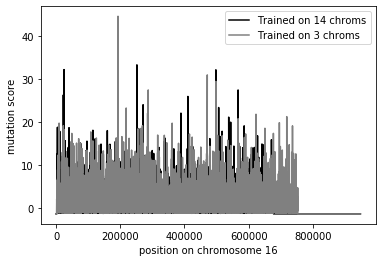

In [5]:
mutation_map = np.sum(np.load('../Results_nucleosome/mutazome_CNN_nucleosome_in_vivo.npy'), axis=1)
#mutation_map1 = np.sum(np.load('../Results_nucleosome/mutazome_2001.npy'), axis=1)
mutation_map2 = np.sum(np.load('../Results_nucleosome/mutazome_CNN_nucleosome_in_vivo_chr1_2_3applied_on_chr16.npy')[:, 0],
                       axis=1)
print(np.std(mutation_map))
mutation_map = (mutation_map - np.mean(mutation_map[:600000])) / np.std(mutation_map[:600000])
#mutation_map1 = (mutation_map1 - np.mean(mutation_map1)) / np.std(mutation_map1)
mutation_map2 = (mutation_map2 - np.mean(mutation_map2[:600000])) / np.std(mutation_map2[:600000])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(mutation_map, 'k', label='Trained on 14 chroms')
ax.plot(mutation_map2, 'gray', label='Trained on 3 chroms')
ax.set_facecolor('white')
ax.set(xlabel='position on chromosome 16', ylabel='mutation score')
ax.legend()


In [ ]:
mut_score = np.sum(mutation_map[:605000], axis=1)

In [7]:
position = pd.read_csv('./Start_data/genes_cerevisiae.csv', sep='\t', names=['chr', 'source', 'type', 'Start',
                                                                             'Stop', '0', 'Strand', '1', '2'])
position = position[position.type == 'gene'].drop(['source', 'type', '0', '1', '2'], axis=1)

num_to_roman = {1 : 'I',
                2 : 'II',
                3 : 'III',
                4 : 'IV',
                5 : 'V',
                6 : 'VI',
                7 : 'VII',
                8 : 'VIII',
                9 : 'IX',
                10 : 'X',
                11 : 'XI',
                12 : 'XII',
                13 : 'XIII',
                14 : 'XIV',
                15 : 'XV',
                16 : 'XVI'}

position.head()

,chr,Start,Stop,Strand
1,I,335,649,+
5,I,538,792,+
9,I,1807,2169,-
13,I,2480,2707,+
17,I,7235,9016,-


In [ ]:
import pyBigWig

chrom_size = pd.read_csv('Start_data/sacCer3.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
bw_header =[('chr' + num_to_roman[i], chrom_size[chrom_size.chrom == 'chr' + num_to_roman[i]].sizes.values[0])\
for i in range(1, 17)]

bw_file = pyBigWig.open('../Results_nucleosome/mutazome_scerevisiae.bw', 'w')
bw_file.addHeader(bw_header)

for chrom in range(1, 17):
    values = zscores['chr' + str(chrom)]
    bw_file.addEntries('chr' + num_to_roman[chrom],
                       1,
                       values=values,
                       span=1,
                       step=1)  
bw_file.close()

In [9]:
gene_positions = dict()
gene_starts = dict()

for chrom in range(1, 17):
    gene_df = position[position.chr == num_to_roman[chrom]]
    gene_plus = gene_df[gene_df.Strand == '+'].Start.values
    gene_minus = gene_df[gene_df.Strand == '-'].Stop.values
    
    gene_starts['chr' + str(chrom)] = gene_plus
    gene_positions['chr' + str(chrom)] = np.append(gene_plus, gene_minus)

In [10]:
# We import the experimental landscape of nucleosome on chromosome 16 of S.cerevisiae to find the NFR.
WINDOW = 2001
HALF_WX = WINDOW // 2

proba = pd.read_csv('./Start_data/proba_in_vivo.csv')
nfr_starts = dict()
nfr_stops = dict()
nfr_positions = dict()

for chrom in range(1, 17):
    y_true = proba[proba.chr == 'chr' + str(chrom)].value.values[HALF_WX : - HALF_WX]

    # Calculing the NFR positions on every chromosome
    nfr_position = NFR_position(y_true, HALF_WX, position[position.chr == num_to_roman[chrom]])
    nfr_start = nfr_position[nfr_position.strand == '+'].nfr_pos.values + HALF_WX
    nfr_stop = nfr_position[nfr_position.strand == '-'].nfr_pos.values + HALF_WX
    nfr_position = nfr_position.nfr_pos.values + HALF_WX # offset between mutazome and y_pred
    
    nfr_starts['chr' + str(chrom)] = nfr_start
    nfr_stops['chr' + str(chrom)] = nfr_stop
    nfr_positions['chr' + str(chrom)] = nfr_position

/users/invites/routhier/Documents/Projet_nucleosomes/Programme/Functions.py:143: RuntimeWarning: invalid value encountered in true_divide
  y /= np.mean(y)
/users/invites/routhier/Documents/Projet_nucleosomes/Programme/Functions.py:146: RuntimeWarning: invalid value encountered in less
  Y[Y < 0.4] = 0
/users/invites/routhier/Documents/Projet_nucleosomes/Programme/Functions.py:149: RuntimeWarning: invalid value encountered in greater
  if (Y[i - wx : i] > 0).any():
/users/invites/routhier/Documents/Projet_nucleosomes/Programme/Functions.py:171: RuntimeWarning: invalid value encountered in greater
  if (Y[i : i + wx]>0).any():


In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(2, 1, 1)
start = 101000
stop = 111000
ax.plot(np.arange(start, stop), zscores['chr16'][start : stop], 'black', )
#ax.bar(x=np.arange(start, stop), height=, width=1, edgecolor='black')
ax.set_facecolor('w') 
ax.set_ylabel('mutation score')

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(1, 2, 2)

ax.hist(mutation_map[:600000],
        bins=1000,
        edgecolor='k',
        density=True,
        label='Trained on 14 chroms',
        color='k')
ax.hist(zscores['chr16'],
        bins=1000,
        edgecolor='gray',
        density=True,
        label='Trained on 3 chroms',
        color='gray')

ax.set_facecolor('w')
ax.set_xlabel('mutazome score')
ax.set_ylabel('density')
ax.legend()

#res = stats.cumfreq(zscores['chr16'], numbins=1000)
#x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
#                                    res.cumcount.size)

#ax2.bar(x, res.cumcount, width=res.binsize, color='royalblue', edgecolor='royalblue')
#ax2.set_title('cumulative histogram')
#ax2.set_facecolor('w')

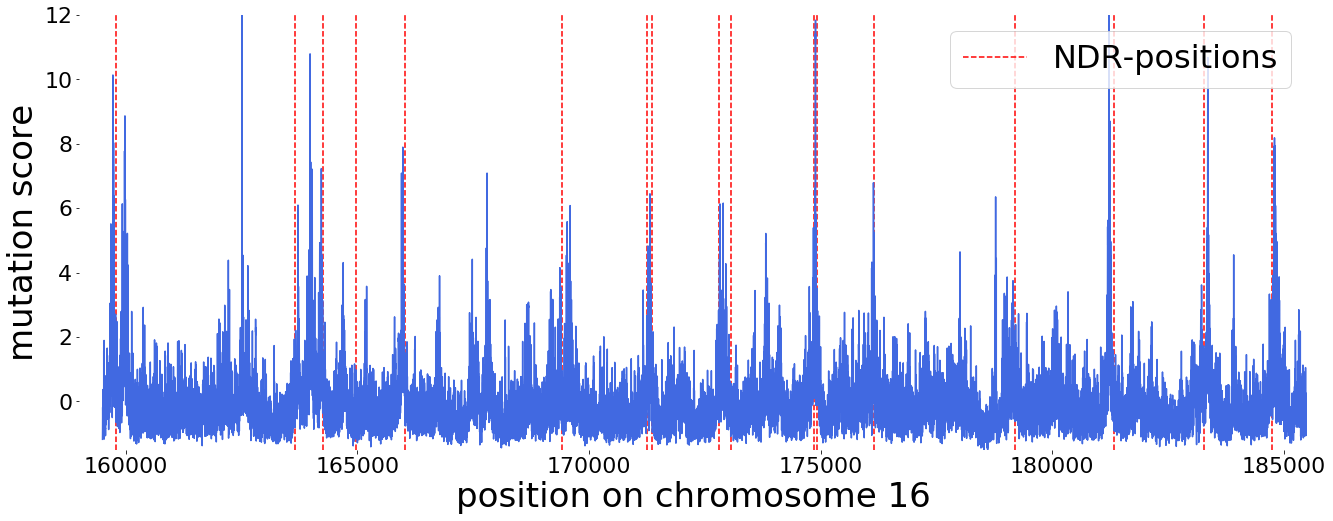

In [11]:
fig = plt.figure(figsize=(22, 8))

ax = plt.axes()
#plt.title('Muteazome on chr16 of S.cerevisiae')
for xc in nfr_positions['chr16'][np.logical_and(nfr_positions['chr16'] > 159500,
                                                nfr_positions['chr16'] < 185500)]:
    plt.axvline(x=xc, color='r', linestyle='--')
#ax.plot(np.sum(mutation_map, axis=1), color='royalblue')
ax.plot(np.arange(159500, 185500, 1),
        zscores['chr16'][159500 : 185500], color='royalblue')
ax.legend(handles=[mlines.Line2D([], [],
                                 color='r',
                                 markersize=34,
                                 linestyle='--',
                                 label="NDR-positions")],
         fontsize=32)
ax.set_xlabel('position on chromosome 16', fontsize=34)
ax.set_ylabel('mutation score', fontsize=34)
ax.set_xticklabels([0, 160000, 165000, 170000, 175000, 180000, 185000], fontsize=22)
ax.set_yticklabels([-2, 0, 2, 4, 6, 8, 10, 12], fontsize=22)
ax.set_ylim(-1.5, 12)
ax.set_xlim(159000, 185500)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

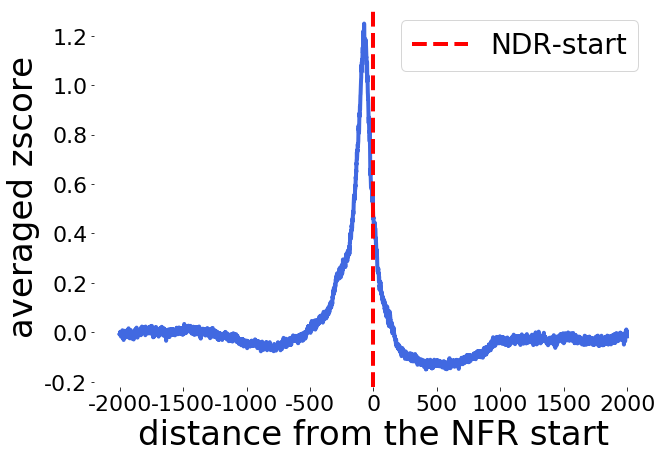

In [12]:
WX = 2000

nfr_region = np.zeros((1, 2 * WX))

for chrom in range(1, 17):
    zscore = zscores['chr' + str(chrom)]
    
    nfr_starts_ = nfr_starts['chr' + str(chrom)][nfr_starts['chr' + str(chrom)] > WX]
    nfr_starts_ = nfr_starts_[nfr_starts_ < len(zscore) - WX]
    
    nfr_stops_ = nfr_stops['chr' + str(chrom)][nfr_stops['chr' + str(chrom)] > WX]
    nfr_stops_ = nfr_stops_[nfr_stops_ < len(zscore) - WX]
    
    nfr_region_start = np.array([zscore[pos - WX : pos + WX]\
                                 for pos in nfr_starts_])
    nfr_region_stop = np.array([zscores['chr' + str(chrom)][pos - WX : pos + WX][::-1]\
                                 for pos in nfr_stops['chr' + str(chrom)][nfr_stops['chr' + str(chrom)] < len(zscore) - WX]])
    nfr_region = np.append(nfr_region, nfr_region_start, axis=0)
    nfr_region = np.append(nfr_region, nfr_region_stop, axis=0)

fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
plt.plot(range(- WX, WX), np.mean(nfr_region[1:], axis=0), color='royalblue', linewidth=4)

ax.set_yticklabels(np.around(np.arange(-0.4, 1.4, 0.2), 1), fontsize=22)
ax.set_xticklabels(np.arange(-2500, 2500, 500), fontsize=22)
ax.set_xlabel('distance from the NFR start', fontsize=34)
ax.set_ylabel('averaged zscore', fontsize=34)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.axvline(x=0, color='r', linestyle='--', linewidth=4)
ax.legend(handles=[mlines.Line2D([], [],
                                 color='r',
                                 linewidth=4,
                                 markersize=34,
                                 linestyle='--',
                                 label="NDR-start")],
         fontsize=28,
         loc='best')

We study the coherence length in the mutazome

In [ ]:
nfr_distances = (nfr_position[1:] - nfr_position[:-1])
nfr_distances = nfr_distances[nfr_distances > 0]
nfr_distances = nfr_distances[nfr_distances < 4000]

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=100, num=1)
ax1.plot([pearsonr(z_score[i:], z_score[:-i])[0] for i in range(1, 4000)])
ax2.hist(nfr_distances, bins=20, density=False, histtype='step')
ax1.set(xlabel='Offset', ylabel='Autocorrelation of the mutazome')


### Important motives in nucleosome positioning

In [5]:
nucleotides = dict()

for chrom in range(1, 17):

    f = h5py.File('./seq_chr_sacCer3/sacCer3/chr' + str(chrom) + '.hdf5',
                  'r')
    nucleotid = np.array(f['data'])
    f.close()
    nucleotides['chr' + str(chrom)] = nucleotid[:, 0]

We look at the mean mutation score for every possible 5 bp motives.

In [14]:
mutation_peaks = {'chr' + str(chrom) : np.where(zscores['chr' + str(chrom)] > 5)[0] for chrom in range(1, 17)}

In [15]:
np.sum([len(mutation_peaks['chr' + str(chrom)]) for chrom in range(1, 17)])

59992

In [16]:
motives_ = np.zeros((1, 5))
motif_per_chr = dict()

for chrom in range(1, 17):
    motif_per_chr['chr' + str(chrom)] = np.array([nucleotides['chr' + str(chrom)][peak - 2 : peak + 3]\
                                                  for peak in mutation_peaks['chr' + str(chrom)]])
    motives_ = np.append(motives_,
                         motif_per_chr['chr' + str(chrom)],
                         axis=0)

motives, counts = np.unique(motives_[1:], axis=0, return_counts=True)

sorter = np.argsort(counts)[::-1]
counts = counts[sorter]
motives = motives[sorter]

In [17]:
num_letter = dict()
num_letter[1] = 'A'
num_letter[2] = 'T'
num_letter[3] = 'G'
num_letter[4] = 'C'

In [18]:
letter_num = dict()
for num, letter in num_letter.items():
    letter_num[letter] = num

In [19]:
def string_to_list(string):
    return [letter_num[letter] for letter in string]

def list_to_string(list_):
    return ''.join(num_letter[num] for num in list_)

In [20]:
def find_where(motif, nucleotid, end=None):
    if not end:
        end = len(nucleotid)
    return np.where(np.sum((rolling_window(nucleotid[:end], window=5) == motif).astype(int), axis=1) == 5)[0] + 2

In [ ]:
binding_sites = dict()
chars = True

with open('/users/invites/routhier/Documents/Projet_nucleosomes/Programme/Start_data/PMW_binding_site.txt', 'r') as f:
    pattern = re.compile('>letter-probability matrix \w+: alength= \d+ w= \d+ nsites= \d+ E= \d+')
    
    while chars:
        chars = f.readline()
        
        if pattern.match(chars):
            name = re.findall("\w+:", chars)[0][:-1]
            size = int(re.findall("\d+", chars)[2])
        elif chars == '':
            print(chars)
        else:
            matrix = [[float(number) for number in re.findall("\d+\.\d+", chars)]]
            for i in range(size-1):
                line = f.readline()
                matrix.append([float(number) for number in re.findall("\d+\.\d+", line)])
            matrix = np.array(matrix)
            binding_sites[name] = matrix
                  

In [ ]:
for name, array in binding_sites.items():
    for i in range(len(array)):
        array[i, :] /= np.sum(array[i, :])
    binding_sites[name] = array

In [22]:
from scipy.stats import binom_test

probabilities = dict()
p_value = dict()
list_of_counts = dict()

size_genome = float(np.sum([len(nucleotides['chr' + str(chrom)]) for chrom in range(1, 17)]))

for motif, count in zip(motives, counts):
    str_motif = ''.join(num_letter[num] for num in motif)
    probabilities[str_motif] = np.sum([len(find_where(motif, nucleotides['chr' + str(chrom)])) \
                                       for chrom in range(1, 17)]) / size_genome
    p_value[str_motif] = binom_test(x=count,
                                    n=np.sum(counts),
                                    p=probabilities[str_motif],
                                    alternative='greater')
    list_of_counts[str_motif] = count
    
    
p_value_array = np.array(list(p_value.values()))
list_of_motives = np.array(list(p_value.keys()))[np.where(p_value_array < 0.0001)]
len(list_of_motives)

173

In [ ]:
import itertools

np.sum([np.sum([len(find_where([i, j, k, l, m], nucleotides['chr' + str(chrom)])) \
            for chrom in range(1, 17)]) for i, j, k, l, m in itertools.product(*[range(1, 5),
                                                                                 range(1, 5),
                                                                                 range(1, 5),
                                                                                 range(1, 5),
                                                                                 range(1, 5)])])
        

In [23]:
def find_group_of_motif(motif_str, nb_mutation=1):
    motif_list = np.array(string_to_list(motif_str))
    match_list = np.sum(np.sign(np.abs([motif_list - np.array([1., 1., 1., 1., 1.]),
                                        motif_list - np.array([2., 2., 2., 2., 2.]),
                                        motif_list - np.array([3., 4., 3., 4., 3.]),
                                        motif_list - np.array([4., 3., 4., 3., 4.])])), axis=1)
    if np.min(match_list) > nb_mutation:
        return 0
    else:
        return np.argmin(match_list) + 1

In [24]:
list_of_motives = np.array(list(p_value.keys()))[np.where(p_value_array < 0.0001)]
#list_of_motives = [''.join(num_letter[num] for num in motif) for motif in motives[np.argsort(p_value_array)]]
list_of_motives[:5]

array(['TTTTT', 'AAAAA', 'TTTTC', 'GAAAA', 'AAAAT'], dtype='<U5')

In [25]:
list_of_group = np.array([find_group_of_motif(motif, 2) for motif in list_of_motives])

In [26]:
list_TTTTT = list_of_motives[list_of_group == 2]
list_AAAAA = list_of_motives[list_of_group == 1]
list_GCGCG = list_of_motives[list_of_group == 3]
list_CGCGC = list_of_motives[list_of_group == 4]

In [ ]:
total_count = np.sum(np.array(list(list_of_counts.values())))

for name, counts in list_of_counts.items():
    list_of_counts[name] /= total_count
list_of_counts

In [ ]:
def motif_to_one_hot(str_motif):
    motif = np.array([letter_num[letter] for letter in str_motif])
    one_hot_motif = np.zeros((5, 4))
    
    for i in range(5):
        one_hot_motif[i, motif[i] - 1] = 1
    return one_hot_motif

In [ ]:
list_of_motives_score = dict()

for str_motif in list_of_motives:
    motif = [letter_num[letter] for letter in str_motif]
    list_of_motives_score[str_motif] = np.mean(z_score[find_where(motif)])
list_of_motives_score   

In [ ]:
for motif in list_of_motives:
    plot_logo(motif_to_one_hot(motif))

In [ ]:
def non_linearity(num):
    return num**2

In [ ]:
binding_score = dict()

for name, binding_site in binding_sites.items():
    bind_score = 0
    
    if name != 'ZMS1':
        decomposition = rolling_window(binding_site, window=(5,4)).reshape((-1, 5, 4))
    
        for motif in list_of_motives:
            one_hot_motif = motif_to_one_hot(motif)
            weight = list_of_counts[motif]
            bind_score += weight * np.mean([non_linearity(np.sum(np.multiply(decomposition[i], one_hot_motif))) for i in range(len(decomposition))])

    binding_score[name] = bind_score

In [ ]:
mean_score = 0
decomposition = np.ones((1, 5, 4)) * 0.25

for motif in list_of_motives:
    one_hot_motif = motif_to_one_hot(motif)
    weight = list_of_counts[motif]
    mean_score += weight * np.mean([non_linearity(np.sum(np.multiply(decomposition[i], one_hot_motif))) for i in range(len(decomposition))])

mean_score    

In [ ]:
scores = np.array(list(binding_score.values()))
scores = (scores - mean_score) / np.std(scores)

In [ ]:
for i in range(len(scores)):
    binding_score[list(binding_score.keys())[i]] = scores[i]

In [ ]:
fig, ax = plt.subplots()

ax.hist(list(binding_score.values()), bins=100)

In [ ]:
np.array(list(binding_score.keys()))[np.argsort(np.array(list(binding_score.values())))[::-1]][:10]

In [ ]:
binding_score['RAP1']

In [ ]:
for motif in np.array(list(binding_score.keys()))[np.argsort(np.array(list(binding_score.values())))[::-1]][:10]:
    plot_logo(binding_sites[motif])

In [ ]:
for name, score  in binding_score.items():
    print(name, score)
    plot_logo(binding_sites[name])

In [138]:
fp = FontProperties(family="Arial", weight="bold") 
globscale = 1.35
LETTERS = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }
COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen'}

def _letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def plot_logo(motif, index=None):
    """
        Plot a logo associated to a motif, the motif must be a numpy array with 1 standing for A, 2 for T, 3 for G
        and 4 for C.
    """
    #motif = (np.arange(4) == motif[...,None]-1).astype(int)
    #motif = motif.reshape((motif.shape[0], 4))

    fig, ax = plt.subplots(figsize=(2.5, 0.7))
    all_scores = [[('A', motif[i, 0]),
                   ('T', motif[i, 1]),
                   ('G', motif[i, 2]),
                   ('C', motif[i, 3])] for i in range(motif.shape[0])]
    ax.set_facecolor('w')   
    ax.set_axis_off()
    
    if index is not None:
        ax.text(0, 1.1, 'Distance to NFR: {}'.format(mode_distances_to_nfr[index]))
        ax.text(0, 1.25, 'Mean peaks height: {}'.format(mean_motives_score[index]))

    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            _letterAt(base, x,y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    plt.xticks(range(1,x))
    plt.xlim((0, x)) 
    plt.ylim((0, maxi)) 
    plt.tight_layout()  
    plt.show()

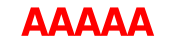

In [583]:
plot_logo(np.array([[1, 0, 0, 0], [1, 0, 0, 0], [1, 0 ,0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]))

### Basics statistics on peaks and motifs

Text(0, 0.5, 'Pourcentage of peak within the range')

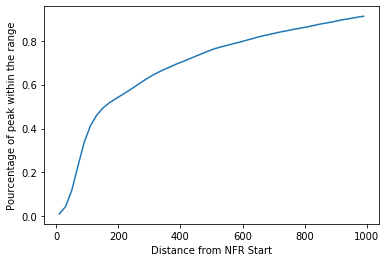

In [428]:
def pc_peaks_in_nfr_chr(length, chrom):
    distance_peaks = distance_to_list(mutation_peaks['chr' + str(chrom)], nfr_starts['chr' + str(chrom)])[0]
    pc_plus = len(distance_peaks[np.logical_and(distance_peaks>=-length,
                                      distance_peaks<=0)]) / float(len(mutation_peaks['chr' + str(chrom)]))

    distance_peaks = distance_to_list(mutation_peaks['chr' + str(chrom)], nfr_stops['chr' + str(chrom)])[0]
    pc_moins = len(distance_peaks[np.logical_and(distance_peaks>=0,
                                  distance_peaks<=length)]) / float(len(mutation_peaks['chr' + str(chrom)]))
    return pc_plus + pc_moins

def pc_peaks_in_nfr(length):
    pc_ar = np.zeros((16,))
    weights = np.zeros((16,))
    for i in range(16):
        pc_ar[i] = pc_peaks_in_nfr_chr(length, i + 1)
        weights[i] = len(mutation_peaks['chr' + str(chrom)])
    return np.average(pc_ar, weights=weights / np.sum(weights))

fig = plt.figure()
ax = fig.add_subplot()

scale = np.arange(10, 1000, 20)
ax.plot(scale, [pc_peaks_in_nfr(length) for length in scale])
ax.set_xlabel('Distance from NFR Start')
ax.set_ylabel('Pourcentage of peak within the range')

## Distribution of motifs under peaks

### Distribution of important motifs

([<matplotlib.patches.Wedge at 0x7f4983441278>,
 [Text(1.5930509287624073, -0.7714199494239393, 'Pure'),
  Text(1.6942695932760554, 0.5122016646792459, '1 mut'),
  Text(-1.446305321797836, 1.0203435284938396, '2 mut'),
  Text(0.3911198674386105, -1.8184128379701912, 'other')],
 [Text(0.8730279101127314, -0.4227555655035146, ' '),
  Text(0.9284980256936572, 0.2806980874230895, '21.4'),
  Text(-0.7926080012112434, 0.5591713122254375, '49.7'),
  Text(0.22289626854028338, -1.0362997893808614, '26.6')])

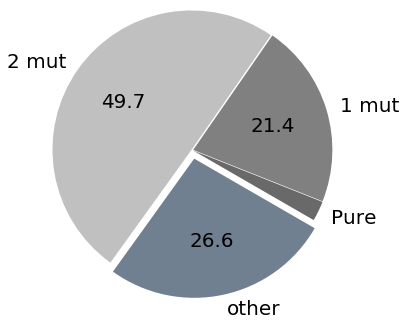

In [597]:
nb_pure = 4
nb_1_mut = len([find_group_of_motif(motif, 1) for motif in list_of_motives \
                if find_group_of_motif(motif, 1) > 0]) - 4
nb_2_mut = len([find_group_of_motif(motif, 2) for motif in list_of_motives \
                if find_group_of_motif(motif, 2) > 0]) - nb_1_mut - 4
other = len(list_of_motives) - nb_2_mut - nb_1_mut - nb_pure

plt.pie([nb_pure, nb_1_mut, nb_2_mut, other], 
        labels=['Pure', '1 mut', '2 mut', 'other'],
        colors=['dimgray', 'gray', 'silver', 'slategrey'],
        explode=(0.01, 0.01, 0.01, 0.1),
        radius=1.6,
        autopct=autopct,
        textprops={'fontsize' : 20},
        startangle=-30)

In [601]:
def find_distance_peaks_nfr():
    distances = np.array([])
    
    for chrom in range(1, 17):
        min_distances_chr, minimal_indexes_chr = distance_to_list(mutation_peaks['chr' + str(chrom)],
                                                                  nfr_positions['chr' + str(chrom)])
        distances = np.append(distances, min_distances_chr, axis=0)
    return np.abs(distances)



In [613]:
def motifs_in_peaks(distance_to_nfr=None):
    if distance_to_nfr:
        distances = find_distance_peaks_nfr()
        motifs = motives_[1:][np.logical_and(distances>=distance_to_nfr[0],
                                             distances<=distance_to_nfr[1])]
    else:
        motifs = motives_[1:]
    
    nb_pure = len([find_group_of_motif(list_to_string(motif), 0) for motif in motifs \
                    if find_group_of_motif(list_to_string(motif), 0) > 0])
    nb_1_mut = len([find_group_of_motif(list_to_string(motif), 1) for motif in motifs \
                    if find_group_of_motif(list_to_string(motif), 1) > 0]) - nb_pure
    nb_2_mut = len([find_group_of_motif(list_to_string(motif), 2) for motif in motifs \
                    if find_group_of_motif(list_to_string(motif), 2) > 0]) - nb_1_mut - nb_pure
    other = len(motifs) - nb_2_mut - nb_1_mut - nb_pure

    proportion = np.array([nb_pure, nb_1_mut, nb_2_mut, other])
    proportion = proportion / np.sum(proportion)

    plt.pie(proportion, 
            labels=['Pure', '1 mut', '2 mut', 'other'],
            colors=['dimgray', 'gray', 'silver', 'slategrey'],
            explode=(0.01, 0.01, 0.01, 0.1),
            radius=1.6,
            autopct=autopct,
            textprops={'fontsize' : 20},
            startangle=-30)

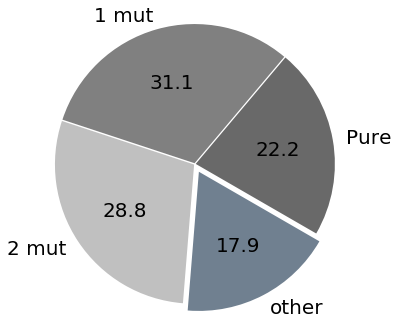

In [606]:
motifs_in_peaks()

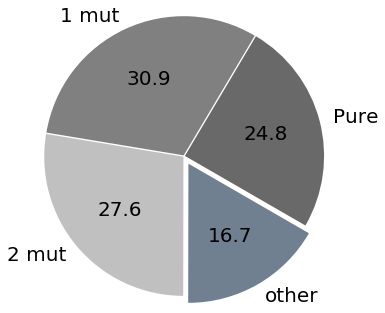

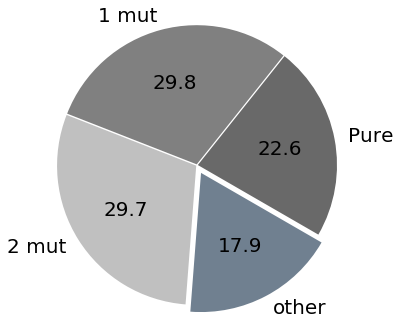

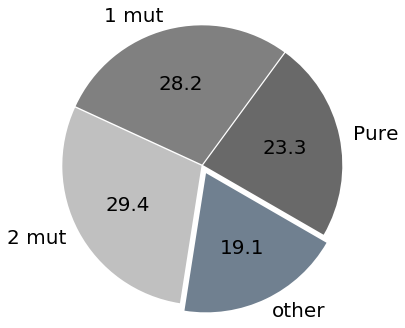

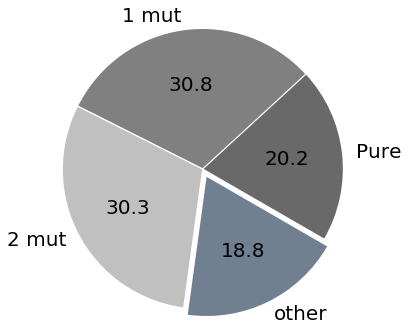

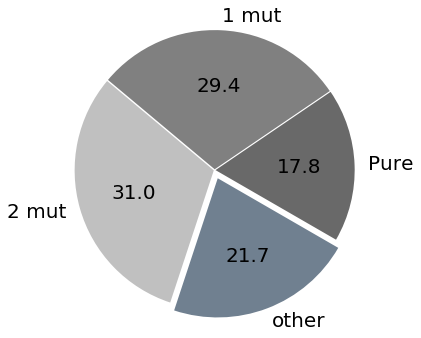

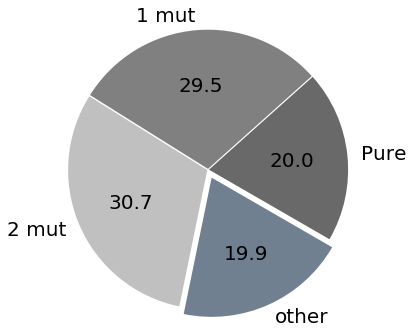

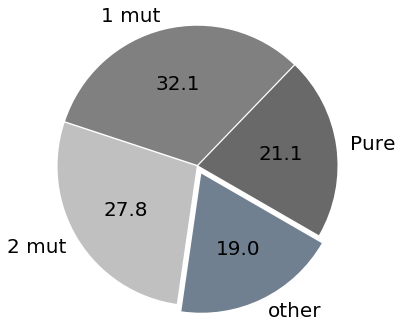

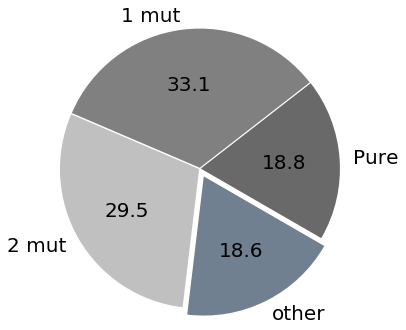

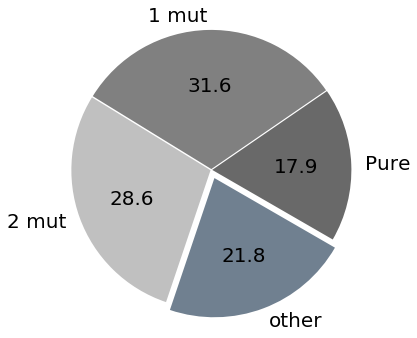

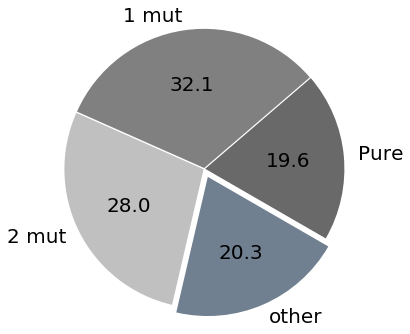

In [615]:
for i, j in zip(np.arange(0, 1000, 100), np.arange(100, 1100, 100)):
    fig = plt.figure()
    motifs_in_peaks(distance_to_nfr=[i, j])

In [616]:
def pc_motif_in_nfr_chr(motif, chrom):
    motif_positions = find_where(string_to_list(motif), nucleotides['chr' + str(chrom)])
    distance_peaks = distance_to_list(motif_positions, nfr_starts['chr' + str(chrom)])[0]
    pc_plus = len(distance_peaks[np.logical_and(distance_peaks>=-200,
                                      distance_peaks<=0)]) / float(len(motif_positions))

    distance_peaks = distance_to_list(motif_positions, nfr_stops['chr' + str(chrom)])[0]
    pc_moins = len(distance_peaks[np.logical_and(distance_peaks>=0,
                                  distance_peaks<=200)]) / float(len(motif_positions))
    return pc_plus + pc_moins

def pc_motif_in_nfr(motif):
    pc_ar = np.zeros((16,))
    weights = np.zeros((16,))
    for i in range(16):
        pc_ar[i] = pc_motif_in_nfr_chr(motif, i + 1)
        weights[i] = len(mutation_peaks['chr' + str(chrom)])
    return np.average(pc_ar, weights=weights / np.sum(weights))

def mean_pc_motif_in_nfr(nb_mutation):
    if nb_mutation == 'random':
        motif_list = [''.join(np.random.choice(['A', 'T', 'G', 'C'], 5)) for _ in range(500)]
        motif_list = [motif for motif in motif_list if motif not in list_of_motives]
        
    else:
        motif_list = list_of_motives[np.array([find_group_of_motif(motif, nb_mutation)\
                                               for motif in list_of_motives]) > 0]
        if nb_mutation > 0:
            previous_list = list_of_motives[np.array([find_group_of_motif(motif, nb_mutation - 1)\
                                               for motif in list_of_motives]) > 0]
            motif_list = [motif for motif in motif_list if motif not in previous_list]
    return np.mean([pc_motif_in_nfr(motif) for motif in motif_list])

mean_pc_in_nfr = [mean_pc_motif_in_nfr(i) for i in [0, 1, 2, 'random']]

Text(0, 0.5, 'Proportion in NFR')

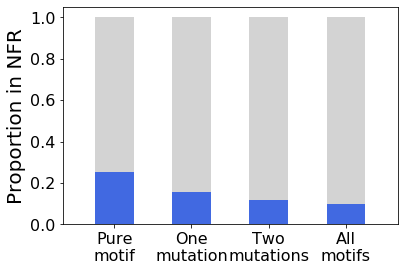

In [617]:
fig = plt.figure()
ax = fig.add_subplot()

ax.bar(x=[0.08, 0.2, 0.32, 0.44], height=mean_pc_in_nfr, color='royalblue', width=0.06)
plt.bar(x=[0.08, 0.2, 0.32, 0.44], height= 1 - np.array(mean_pc_in_nfr),
        width=0.06, bottom=mean_pc_in_nfr, color='lightgrey')
ax.set_xticks([0.08, 0.2, 0.32, 0.44])
ax.set_xlim([0, 0.52])
ax.set_xticklabels(['Pure\nmotif', 'One\nmutation', 'Two\nmutations', 'All\nmotifs'], fontsize=16)
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
ax.set_ylabel('Proportion in NFR', fontsize=20)

### Proportion of motifs detected as important

In [668]:
pure_motif, one_mut, two_mut = [], [], []

for i, motif in enumerate(motives):    
    all_occurence = np.sum([len(find_where(motif, nucleotides['chr' + str(chrom)]))\
                     for chrom in range(1, 17)])
    
    if find_group_of_motif(list_to_string(motif), 0) > 0:
        pure_motif.append(counts[i] / float(all_occurence))
    
    elif find_group_of_motif(list_to_string(motif), 1) > 0:
        one_mut.append(counts[i] / float(all_occurence))
    
    elif find_group_of_motif(list_to_string(motif), 2) > 0:
        two_mut.append(counts[i] / float(all_occurence))

mean_pc_motif_detected = [np.mean(pure_motif), np.mean(one_mut), np.mean(two_mut)]

In [745]:
mean_pc_motif_detected

[0.1678470277402701, 0.038235206582170535, 0.008986449712673109]

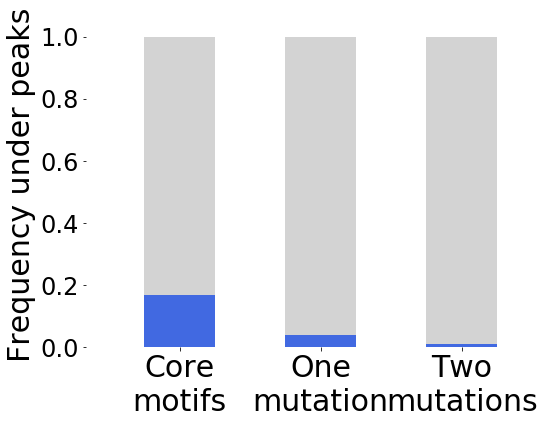

In [816]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

ax.bar(x=[0.08, 0.2, 0.32], height=mean_pc_motif_detected, color='royalblue', width=0.06)
plt.bar(x=[0.08, 0.2, 0.32], height= 1 - np.array(mean_pc_motif_detected),
        width=0.06, bottom=mean_pc_motif_detected, color='lightgrey')
ax.set_xticks([0.08, 0.2, 0.32])
ax.set_xlim([0, 0.38])
ax.set_xticklabels(['Core\nmotifs', 'One\nmutation', 'Two\nmutations'], fontsize=30)
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=24)
ax.set_ylabel('Frequency under peaks', fontsize=30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

## Positioning or anti-positioning motifs

We try to predict the effect of the motifs found to be important in the process of nucleosome positioning.
To do so we predict the wilde type occupancy near the motif and compare it with the mutated type coverage.

### Density on all the example of motifs

In [704]:
proba = pd.read_csv('Start_data/proba_in_vivo.csv')
threshold = nuc_occupancy('Start_data/proba_in_vivo.csv',
                          return_threshold=True,
                          train_chr=range(2, 14),
                          val_chr=range(14, 16))

densities = {'chr' + str(chrom) :\
             proba[proba.chr == 'chr' + str(chrom)].value.values / threshold for chrom in range(1, 17)}


In [725]:
def density_around_motif_chr(motif, chrom, distances_limits=None, width=100):
    positions = find_where(string_to_list(motif), nucleotides['chr' + str(chrom)])
    positions = positions[positions > width]
    positions = positions[positions < len(nucleotides['chr' + str(chrom)]) - width]
    
    if distances_limits:
        distances_chr, _ = np.abs(distance_to_list(positions,
                                                   nfr_positions['chr' + str(chrom)]))
        positions = positions[np.logical_and(distances_chr>=distances_limits[0],
                                             distances_chr<=distances_limits[1])]
    
    density_array = densities['chr' + str(chrom)]
    density_around = np.concatenate([density_array[pos - 100 : pos + 100].reshape((-1, 1))\
                                     for pos in positions], axis=1)
    return density_around

def density_around_motif(motif, distances_limits=None, width=100):
    density_around = np.concatenate([density_around_motif_chr(motif, chrom, distances_limits, width)\
                                     for chrom in range(1, 17)], axis=1)
    return np.mean(density_around, axis=1)
        

[]

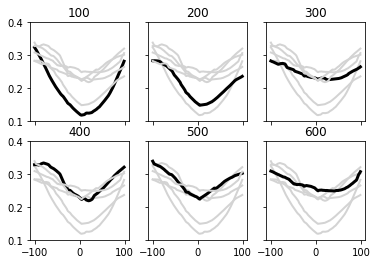

In [741]:
def plot_ax(ax, motif, width, emphasize_on):
    for i, j in zip(np.arange(0, 600, 100), np.arange(100, 700, 100)):
        if i == emphasize_on:
            ax.plot(np.arange(-width, width, 1),
                density_around_motif(motif, distances_limits=[i, j]),
                'k', 
                linewidth=3)
        else:
            ax.plot(np.arange(-width, width, 1),
                    density_around_motif(motif, distances_limits=[i, j]),
                    'lightgrey',
                    linewidth=2)
    ax.set_ylim([0.1, 0.4])
    ax.set_title(str(emphasize_on + 100))
    

fig = plt.figure()
width = 100
motif = 'TTTTT'
ax = fig.add_subplot(231)
plot_ax(ax, motif, width, 0)
plt.setp(ax, xticklabels=[])

ax1 = fig.add_subplot(232)
plot_ax(ax1, motif, width, 100)
plt.setp(ax1, xticklabels=[])
plt.setp(ax1, yticklabels=[])

ax2 = fig.add_subplot(233)
plot_ax(ax2, motif, width, 200)
plt.setp(ax2, xticklabels=[])
plt.setp(ax2, yticklabels=[])

ax3 = fig.add_subplot(234)
plot_ax(ax3, motif, width, 300)

ax4 = fig.add_subplot(235)
plot_ax(ax4, motif, width, 400)
plt.setp(ax4, yticklabels=[])

ax5 = fig.add_subplot(236)
plot_ax(ax5, motif, width, 500)
plt.setp(ax5, yticklabels=[])


### Selected exemple of motifs considered as important

In [27]:
def position_motif(motif, chrom):
    pos_in_motives_ = np.where(np.sum((motif_per_chr['chr' + str(chrom)] == motif).astype(int), axis=1) == 5)[0]
    return mutation_peaks['chr' + str(chrom)][pos_in_motives_]

Firstly, we want to reconstruct the strandard promotor region with the associated motifs and distances.

In [28]:
def distance_to_list(datalist, comparator):
    """Return for every point of datalist the minimal algebric distance to a point of comparator,
    a positive result mean that the datapoint is after the comparator point."""
    
    min_distances = np.zeros(len(datalist))
    minimal_indexes = []
    for idx, datapoint in enumerate(datalist):
        minimal_index = np.argmin(np.abs(comparator - datapoint))
        min_distances[idx] = datapoint - comparator[minimal_index]
        minimal_indexes.append(minimal_index)
    return min_distances, np.array(minimal_indexes)

In [29]:
def distance_to_tss(motif_lst):
    """Return the minimal distance between all occurence of a motif and a tss as well as the strand of the 
    closest tss. It returns a list with distances"""
    
    distances, strands = np.array([]), np.array([])
    
    for i in range(1, 17):
        min_distances_chr, minimal_indexes_chr = distance_to_list(position_motif(motif_lst, i),
                                                                  gene_positions['chr' + str(i)])
        distances = np.append(distances, min_distances_chr, axis=0)
        maxlen = len(gene_starts['chr' + str(i)])
        strands = np.append(strands,
                            np.array([1 if idx < maxlen else -1 for idx in minimal_indexes_chr]))
    return distances * strands

In [30]:
def distance_to_tss_chr(motif_lst, chrom):
    min_distances_chr, minimal_indexes_chr = distance_to_list(position_motif(motif_lst, chrom),
                                                              gene_positions['chr' + str(chrom)])
    maxlen = len(gene_starts['chr' + str(chrom)])
    strands = np.array([1 if idx < maxlen else -1 for idx in minimal_indexes_chr])
    return min_distances_chr * strands, minimal_indexes_chr

In [31]:
motifs_to_test = ['AAAAA', 'TTTTT', 'CGCGC', 'GCGCG']
distance_to_tss_df = pd.DataFrame()

for motif in motifs_to_test:
    distance_to_tss_df_ = pd.DataFrame()
    distance_to_tss_df_['distances'] = distance_to_tss(string_to_list(motif))
    distance_to_tss_df_['motif'] = motif
    distance_to_tss_df = distance_to_tss_df.append(distance_to_tss_df_)

In [ ]:
sns.boxplot(x="motif", y="distances",
               data=distance_to_tss_df, palette="muted")


We now know that the motifs are not strand specific, we will try to reconstruct a promotor sequence. To do so we associate to a TSS its corresponding NFR, then the corresponding motifs.

In [32]:
def separate_intersection(ar1, ar2):
    intersection, del1, del2 = np.intersect1d(ar1, ar2, return_indices=True)
    non_intersection = np.delete(ar1, del1)
    return intersection, non_intersection

def separate_4arrays(ar1, ar2, ar3, ar4):
    inter12, inter1 = separate_intersection(ar1, ar2)

    inter123, inter12 = separate_intersection(inter12, ar3)
    inter13, inter1 = separate_intersection(inter1, ar3)

    inter1234, inter123 = separate_intersection(inter123, ar4)
    inter124, inter12 = separate_intersection(inter12, ar4)
    inter134, inter13 = separate_intersection(inter13, ar4)
    inter14, inter1 = separate_intersection(inter1, ar4)
    return inter1, inter12, inter13, inter14, inter123, inter124, inter134, inter1234

def all_subset(ar1, ar2, ar3, ar4):
    inter1, inter12, inter13, inter14, inter123, inter124, inter134, inter1234 = separate_4arrays(ar1, ar2, ar3, ar4)
    inter2, _, inter23, inter24, _, _, inter234, _ = separate_4arrays(ar2, ar1, ar3, ar4)
    inter3, _, _, inter34, _, _, _, _ = separate_4arrays(ar3, ar2, ar1, ar4)
    inter4, _, _, _, _, _, _, _ = separate_4arrays(ar4, ar2, ar3, ar1)
    return inter1, inter2, inter3, inter4, inter12, inter13, inter14, inter23, inter24,\
           inter34, inter123, inter124, inter134, inter234, inter1234


In [38]:
def find_tss_with_motifs(motif_lst, chrom):
    distances, indexes = distance_to_list(position_motif(motif_lst, chrom), gene_positions['chr' + str(chrom)])
    tss_with_motifs = np.unique(indexes[np.logical_and(distances>=-600, distances<=200)])
    return tss_with_motifs

def find_tss_to_nfr_distance(chrom):
    distances_nfr_tss = distance_to_list(gene_positions['chr' + str(chrom)],
                                         nfr_positions['chr' + str(chrom)])[0]
    return np.abs(distances_nfr_tss)

def find_intersection_tss(chrom):
    motifs = ['AAAAA', 'TTTTT', 'CGCGC', 'GCGCG']
    for motif in motifs:
        vars()['tss_' + base_motif] = find_tss_with_motifs(string_to_list(motif), chrom)
    return all_subset(vars()['tss_AAAAA'], vars()['tss_TTTTT'], vars()['tss_CGCGC'], vars()['tss_GCGCG'])

def find_intersection_tss_all(chrom):
    motifs = [('AAAAA', list_AAAAA), ('TTTTT', list_TTTTT),
              ('CGCGC', list_CGCGC), ('GCGCG', list_GCGCG)]
    for base_motif, group_motif in motifs:
        vars()['tss_' + base_motif] = np.array([])
        for motif in group_motif:
            vars()['tss_' + base_motif] = np.append(vars()['tss_' + base_motif],
                                                    find_tss_with_motifs(string_to_list(motif), chrom))
            vars()['tss_' + base_motif] = np.unique(vars()['tss_' + base_motif])
    return all_subset(vars()['tss_AAAAA'], vars()['tss_TTTTT'], vars()['tss_CGCGC'], vars()['tss_GCGCG'])

def calculate_size_subset_chr(chrom):
    subsets = find_intersection_tss_all(chrom)
    nb_tss_chrom = len(gene_positions['chr' + str(chrom)])
    pc_subset = [(len(tss_list) * 100 )/ float(nb_tss_chrom) for tss_list in subsets]
    return np.around(pc_subset, 3)

def calculate_size_subset():
    size_subset = np.zeros((16, 15))
    for chrom in range(1, 17):
        size_subset[chrom - 1] = calculate_size_subset_chr(chrom)
    weights = [len(gene_positions['chr' + str(chrom)]) for chrom in range(1, 17)]
    return np.average(size_subset, axis=0, weights=weights / np.sum(weights))

def motifs_in_subset():
    motifs_dict = {0 : ['AAAAA'], 1 : ['TTTTT'], 2 : ['CGCGC'],
                   3 : ['GCGCG'], 4 : ['AAAAA', 'TTTTT'],
                   5 : ['AAAAA', 'CGCGC'],
                   6 : ['AAAAA', 'GCGCG'],
                   7 : ['TTTTT', 'CGCGC'],
                   8 : ['TTTTT', 'GCGCG'],
                   9 : ['CGCGC', 'GCGCG'],
                   10 : ['AAAAA', 'TTTTT', 'CGCGC'],
                   11 : ['AAAAA', 'TTTTT', 'GCGCG'],
                   12 : ['AAAAA', 'CGCGC', 'GCGCG'],
                   13 : ['TTTTT', 'CGCGC', 'GCGCG'],
                   14 : ['AAAAA', 'TTTTT', 'CGCGC', 'GCGCG']}
    return motifs_dict

def calculate_stats_chr(chrom):
    motifs_dict = motifs_in_subset()
    subsets_list = find_intersection_tss_all(chrom)
    list_of_motif_to_tss = []
    list_of_tss_to_nfr = []

    for i in range(len(subsets_list)):
        dico_distance_motif = {}

        for motif in motifs_dict[i]:
            distances_tss_motif, indexes = distance_to_tss_chr(string_to_list(motif), chrom)
            _, distances_indexes, _ = np.intersect1d(indexes, subsets_list[i], return_indices=True)
            distances_tss_motif = distances_tss_motif[distances_indexes]
            dico_distance_motif = {**dico_distance_motif, **{motif : distances_tss_motif}}

        list_of_motif_to_tss.append(dico_distance_motif)
        list_of_tss_to_nfr.append(find_tss_to_nfr_distance(chrom)[subsets_list[i].astype(int)])
    return list_of_motif_to_tss, list_of_tss_to_nfr

def calculate_stat():

    for chrom in range(1, 17):

        if chrom == 1:
            list_of_motif_to_tss, list_of_tss_to_nfr = calculate_stats_chr(chrom)
        else:
            list_of_motif_to_tss_, list_of_tss_to_nfr_ = calculate_stats_chr(chrom)

            for i, motif_dict in enumerate(list_of_motif_to_tss):
                list_of_motif_to_tss[i] = {motif : np.append(array, list_of_motif_to_tss_[i][motif], axis=0) \
                                          for motif, array in motif_dict.items()}

            for i, array in enumerate(list_of_tss_to_nfr):
                list_of_tss_to_nfr[i] = np.append(array, list_of_tss_to_nfr_[i], axis=0)

    return list_of_motif_to_tss, list_of_tss_to_nfr

def plot_box(motifs, idx_subsets, palette, fig_height=1):
    list_of_motif_to_tss, list_of_tss_to_nfr = calculate_stat()
    promotors_data = pd.DataFrame()
    
    def merge_subsets(motif, idx_subsets):
        array = np.array([])
        for idx_subset in idx_subsets:
            try:
                array = np.append(array, list_of_motif_to_tss[idx_subset][motif], axis=0)
            except KeyError:
                pass
        return array

    for motif in motifs:
        array = merge_subsets(motif, idx_subsets)
        promotors_data_ = pd.DataFrame()
        promotors_data_['distance to TSS'] = array
        promotors_data_['locus'] = motif
        promotors_data = promotors_data.append(promotors_data_)
        print(len(promotors_data_))

    promotors_data_ = pd.DataFrame()
    promotors_data_['distance to TSS'] = - np.concatenate([list_of_tss_to_nfr[idx] for idx in idx_subsets],
                                                           axis=0)
    promotors_data_['locus'] = 'NFR_Start'
    promotors_data = promotors_data.append(promotors_data_)
 
    plt.figure(figsize=(14, fig_height))
    ax = sns.boxplot(x="distance to TSS", y="locus", width=0.4, orient="h",
                     fliersize=1, whis=0.8, palette=palette,
                     data=promotors_data, saturation=0.5,
                     linewidth=7)
    ax.set_xlim([-250, 10])

    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.set_xticklabels(np.arange(-250, 10, 50), fontsize=26)
    ax.set_xlabel('distance to TSS', fontsize=26)

    ax.set_yticklabels(motifs + ['NDR Start'], fontsize=26)
    ax.set_ylabel('')


1023
160


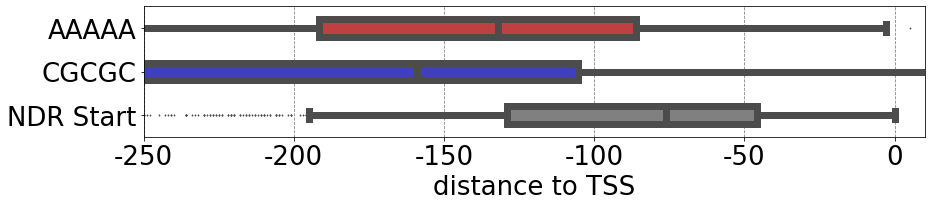

In [43]:
plot_box(['AAAAA','CGCGC'], [5, 6, 10, 11, 12, 14], ['r', 'b', 'grey'], 2.4)

([<matplotlib.patches.Wedge at 0x7fc760309438>,
 [Text(1.7696490690576359, 0.035244465997417776, 'A-T'),
  Text(1.1168161877272738, 1.3731793775142127, 'C-G'),
  Text(-1.1775181392655016, 1.3214957554607247, 'A-T-C-G'),
  Text(-0.2599784100468159, -1.841741357061173, 'NO MOTIFS')],
 [Text(0.9698076819129416, 0.019314763851692226, '17.3'),
  Text(0.6120405096584492, 0.752533331180105, '10.3'),
  Text(-0.6453065508969131, 0.7242095383033349, '34.6'),
  Text(-0.1481597390589381, -1.049594536819808, '37.8')])

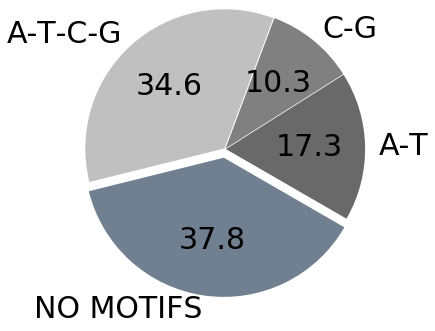

In [37]:
pc_array = calculate_size_subset()
total = np.sum(pc_array)

def autopct(string):
    if float(string) > 5:
        return round(string, 1)
    else:
        return ' '

plt.pie([np.sum(pc_array[[0, 1, 4]]), np.sum(pc_array[[2, 3, 9]]),
         np.sum(pc_array[[5, 6, 7, 8, 10, 11, 12, 13, 14]]), 100 - total], 
        labels=['A-T', 'C-G', 'A-T-C-G', 'NO MOTIFS'],
        colors=['dimgray', 'gray', 'silver', 'slategrey'],
        explode=(0.01, 0.01, 0.01, 0.1),
        radius=1.6,
        autopct=autopct,
        textprops={'fontsize' : 30},
        startangle=-30)



Text(0.5, 1.0, 'Class of promotors \n containing CGCGC motif ')

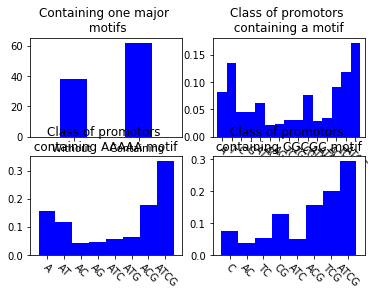

In [467]:

fig = plt.figure()

ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax.bar(x=[0.08, 0.2], height=[100 - total, total], color='b', width=0.05)
ax.set_xticks([0.08, 0.2])
ax.set_xlim([0, 0.28])
ax.set_xticklabels(['Without \n a motif', 'Containing \n a motif'])
ax.set_title('Containing one major \n motifs')

ax1.bar(x=np.arange(1, 16, 1), width=1, color='b', height=(pc_array / total))
ax1.set_xticks(np.arange(1, 16, 1))
ax1.set_xlim([0, 16])
ax1.set_xticklabels(['A', 'T', 'C', 'G', 'AT', 'AC', 'AG', 'TC', 'TG', 'CG',
                     'ATC', 'ATG', 'ACG', 'TCG', 'ATCG'], rotation=-45)
ax1.set_title('Class of promotors \n containing a motif ')

listA = [0, 4, 5, 6, 10, 11, 12, 14]
ax2.bar(x=np.arange(1, 9, 1), width=1, color='b', height=(pc_array[listA] / np.sum(pc_array[listA])))
ax2.set_xticks(np.arange(1, 9, 1))
ax2.set_xlim([0, 9])
ax2.set_xticklabels(['A', 'AT', 'AC', 'AG',
                     'ATC', 'ATG', 'ACG', 'ATCG'], rotation=-45)
ax2.set_title('Class of promotors \n containing AAAAA motif ')

listC = [2, 5, 7, 9, 10, 12, 13, 14]
ax3.bar(x=np.arange(1, 9, 1), width=1, color='b', height=(pc_array[listC] / np.sum(pc_array[listC])))
ax3.set_xticks(np.arange(1, 9, 1))
ax3.set_xlim([0, 9])
ax3.set_xticklabels(['C', 'AC', 'TC','CG',
                     'ATC', 'ACG', 'TCG', 'ATCG'], rotation=-45)
ax3.set_title('Class of promotors \n containing CGCGC motif ')

In [87]:
def _predict_around(positions, strands, chrom, width):
    """
    Function aimed at predicting the wild type and the 3 mutated type coverage around position in positions.
    The coverage is predicted with a range width around the center position for the desired chromosome.
    
    Args:
        positions: positions around which to predict the coverage (positions of mutation also)
        on a particular chromosome
        strands: the strands of genes associated with nfr where the motif are.
        chrom: the chromosome number on which the position will be taken
        width: the coverage will be predicted within a width range around positions
    """
    model = load_model('../Results_nucleosome/weights_CNN_nucleosome_in_vivo_chr1_2_3.hdf5',
                       custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})

    window = 2001
    half_wx = window // 2
    pred_around = np.zeros((len(positions), 2 * width, 4))

    for i in range(4):    
        nucleotid_around = np.array([nucleotides['chr' + str(chrom)][pos - width - half_wx : pos + width + half_wx]\
                                     for pos in positions])
        nucleotid_around[:, half_wx + width] = ((nucleotid_around[:, half_wx + width] + i) % 4) + 1
        nucleotid_around = rolling_window(nucleotid_around, window=(len(nucleotid_around), window))
        nucleotid_around = np.swapaxes(nucleotid_around, 1, 2)
        nucleotid_around = nucleotid_around.reshape(nucleotid_around.shape[1] * 2 * width, window)

        x_one_hot = (np.arange(nucleotid_around.max()) == nucleotid_around[...,None]-1).astype(int)
        x = x_one_hot.reshape((-1, window, 1, 4))

        pred_around_ = model.predict(x)
        pred_around_ = pred_around_.reshape((len(positions), 2 * width))
        pred_around_[np.where(strands == -1)[0]] = pred_around_[np.where(strands == -1)[0], ::-1]
        pred_around[:, :, i] = pred_around_
    return pred_around

In [561]:
def positions_motif_subset(motif, idx_subsets, chrom):
    strand_threshold = len(gene_starts['chr' + str(chrom)])
    subsets_list = find_intersection_tss_all(chrom)
    list_of_motif_to_tss = []

    _, indexes = distance_to_tss_chr(string_to_list(motif), chrom)
    strands = np.array([1 if idx < strand_threshold else -1 for idx in indexes])

    subset_list = np.concatenate([subsets_list[idx_subset] for idx_subset in idx_subsets], axis=0)

    _, positions_indexes, _ = np.intersect1d(indexes, subset_list, return_indices=True)
    positions_motif_in_subset = position_motif(string_to_list(motif), chrom)[positions_indexes]
    strand_associated_tss = strands[positions_indexes]

    return positions_motif_in_subset, strand_associated_tss

In [562]:
def predict_around(motif, idx_subsets, width):
    """ Same as before but for all the positions of a given motif on the whole genome."""
    pred_around = np.zeros((1, 2 * width, 4))
    
    for chrom in range(1, 17):
        positions, strands = positions_motif_subset(motif, idx_subsets, chrom)
        print('length of subset: {}'.format(len(positions)))
        
        if len(positions) > 0:
            pred_around_ = _predict_around(positions,
                                           strands,
                                           chrom,
                                           width) 
            pred_around = np.append(pred_around, pred_around_, axis=0)
        else:
            print('chromosome {} whithout any example'.format(str(chrom)))

    return pred_around[1:]

In [563]:
def plot_effect_mutation(motif, idx_subsets, width):
    pred = predict_around(motif, idx_subsets, width)
    fig = plt.figure(figsize=(5, 3))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(range(-width, width), np.mean(pred, axis=0)[:, 3],
             'royalblue',
             label='WT')
    ax1.plot(range(-width, width), np.mean(np.mean(pred, axis=0)[:, :3], axis=1),
             'r',
             label='Mutated')
    ax1.legend()
    ax1.set_facecolor('w')
    ax1.set_xlabel('distance to the motif center', fontsize=16)
    ax1.set_ylabel('mean coverage', fontsize=16)


length of subset: 9
length of subset: 20
length of subset: 10
length of subset: 46
length of subset: 9
length of subset: 12
length of subset: 36
length of subset: 24
length of subset: 15
length of subset: 26
length of subset: 28
length of subset: 39
length of subset: 36
length of subset: 17
length of subset: 45
length of subset: 41


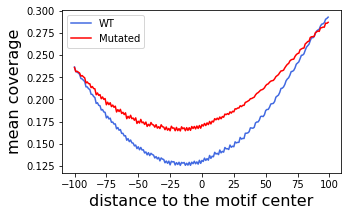

In [578]:
plot_effect_mutation('AAAAA', [0, 4], width=100)

length of subset: 2
length of subset: 6
length of subset: 0
chromosome 3 whithout any example
length of subset: 5
length of subset: 4
length of subset: 1
length of subset: 1
length of subset: 3
length of subset: 1
length of subset: 1
length of subset: 4
length of subset: 7
length of subset: 6
length of subset: 3
length of subset: 3
length of subset: 14


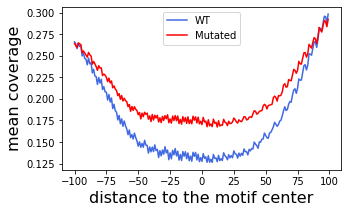

In [579]:
plot_effect_mutation('CGCGC', [2, 9], width=100)

length of subset: 8
length of subset: 48
length of subset: 21
length of subset: 131
length of subset: 45
length of subset: 20
length of subset: 104
length of subset: 57
length of subset: 36
length of subset: 67
length of subset: 72
length of subset: 73
length of subset: 75
length of subset: 78
length of subset: 88
length of subset: 100


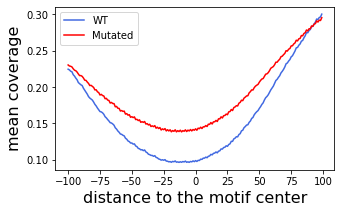

In [580]:
plot_effect_mutation('AAAAA', [5, 6, 10, 11, 12, 14], width=100)

length of subset: 1
length of subset: 21
length of subset: 7
length of subset: 23
length of subset: 10
length of subset: 7
length of subset: 33
length of subset: 9
length of subset: 3
length of subset: 14
length of subset: 7
length of subset: 17
length of subset: 26
length of subset: 18
length of subset: 23
length of subset: 17


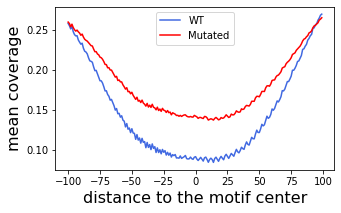

In [582]:
plot_effect_mutation('CGCGC', [5, 7, 10, 12, 13, 14], width=100)

We try to see weither the poly dT-dA are mostly set in the NFR while the CGCGC motifs are in the TSS region.

## Exploring the effect of two mutations

### Mutazome auto-correlation

The goal is to define the typical length of an important site in the mutazome. 

In [122]:
maxrange = 2000

mutazome = np.concatenate([zscores['chr' + str(i)] for i in range(1, 16)], axis=0)
autocorr = [np.corrcoef(mutazome[:-i], mutazome[i:])[0, 1] for i in range(1, maxrange)]

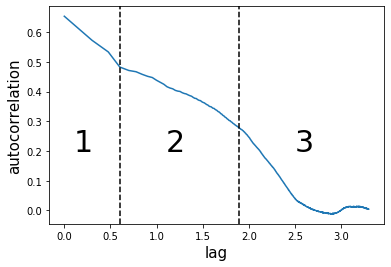

In [136]:
fig, ax = plt.subplots()
ax.plot(np.log10(np.arange(1, len(autocorr) + 1)), autocorr)
#ax.plot([5, 5], [-0.05, autocorr[5]], color='k', linestyle='--')
#ax.plot([14, 14], [-0.05, autocorr[14]], color='k', linestyle='--')
#ax.plot([325, 325], [-0.05, autocorr[325]], color='k', linestyle='--')

ax.set_xlabel('lag', fontsize=15)
ax.set_ylabel('autocorrelation', fontsize=15)
ax.text(s='1', x=0.1, y=0.2, fontsize=30)
ax.text(s='2', x=1.1, y=0.2, fontsize=30)
ax.text(s='3', x=2.5, y=0.2, fontsize=30)

separators = [0.6, 1.9]

for i in separators:
    ax.axvline(i, color='k', linestyle='--')

#for i, j in zip(separators[:-1], separators[1:]):
#    ax.plot([i, j], [autocorr[int(np.exp(i)) - 1], autocorr[int(np.exp(j)) - 1]], 'r')

#ax.set_xlim([-10, 400])
#ax.set_ylim([-0.05, 0.68])
fig.savefig('../Analysis_results/Referee_demand/autocorrelation_mutazome.eps', format='eps')

The typical length of a site is 13 bp. We will take 40 bp as the frontier between same motif peaks and different motif peaks.

### Position of peaks

In [5]:
mutation_peaks = {'chr' + str(chrom) : np.where(zscores['chr' + str(chrom)] > 5)[0] for chrom in range(1, 17)}
mutation_down = {'chr' + str(chrom) : np.where(zscores['chr' + str(chrom)] < 1)[0] for chrom in range(1, 17)}

nucleotides = dict()

for chrom in range(1, 17):

    f = h5py.File('./seq_chr_sacCer3/sacCer3/chr' + str(chrom) + '.hdf5',
                  'r')
    nucleotid = np.array(f['data'])
    f.close()
    nucleotides['chr' + str(chrom)] = nucleotid[:,0]

model = load_model('../Results_nucleosome/weights_CNN_nucleosome_in_vivo_chr1_2_3.hdf5',
                       custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [97]:
def find_accessible_comutation(chrom, index, first_mut='peak', second_mut='peak'):
    mut_peaks = mutation_peaks[chrom]
    mut_down = mutation_down[chrom]

    if first_mut == 'peak':
        peak_position = mut_peaks[index]
    elif first_mut == 'down':
        peak_position = mut_down[index]

    if second_mut == 'peak':
        distance_to_peaks = np.abs(mut_peaks - peak_position)
        accessible_peaks = mut_peaks[np.logical_and(distance_to_peaks > 0,
                                                distance_to_peaks < 500)]

    elif second_mut == 'down':
        distance_to_peaks = np.abs(mut_down - peak_position)
        accessible_peaks = mut_down[np.logical_and(distance_to_peaks > 0,
                                                   distance_to_peaks < 500)]
        distance_to_peaks = distance_to_peaks[np.logical_and(distance_to_peaks > 0,
                                                   distance_to_peaks < 500)]
        
        bins = [0, 5, 14, 325, 2000]
        proba_distribution = np.zeros(accessible_peaks.shape)

        proba = np.array([len(distance_to_peaks[np.logical_and(distance_to_peaks > start,
                                                  distance_to_peaks < stop)])\
            for start, stop in zip(bins[:-1], bins[1:])])
        proba = 1 / proba

        for i, (start, stop) in enumerate(zip(bins[:-1], bins[1:])):
            proba_distribution[np.logical_and(distance_to_peaks > start,
                                                  distance_to_peaks < stop)] = proba[i]
        proba_distribution = proba_distribution / np.sum(proba_distribution)

        accessible_peaks = np.random.choice(accessible_peaks, 10, p=proba_distribution)

    return peak_position, accessible_peaks

def dna_sequence_around_pos(chrom, position):
    window = 2001
    nucleotid = nucleotides[chrom]
    return nucleotid[position - window + 1 : window + position]

def one_hot(seq):
    window = 2001
    x_one_hot = one_hot_encoder(seq)
    x_slide = rolling_window(x_one_hot, window=(window,4))
    return x_slide.reshape((len(x_slide), window, 1, 4))

def loss(y_true, y_pred):
    y_true = y_true.reshape(len(y_true))
    y_pred = y_pred.reshape(len(y_pred))
    return np.mean(np.abs(y_true - y_pred)) + 1 - np.corrcoef(y_true, y_pred)[0, 1] 

def compare_array(y_mut1, y_mut2, y_true):
    delta1 = np.abs(y_mut1 - y_true)
    delta2 = np.abs(y_mut2 - y_true)
    where = np.where(delta1 > delta2)[0]
    
    y_max = y_mut2
    y_max[where] = y_mut1[where]
    return y_max

def calculate_score(y_mut1, y_mut2, y_true, chrom):
    score1 = np.sum([loss(y_mut1[:, i], y_true) for i in range(3)])
    score1 = (score1 - means[chrom]) / stds[chrom]
    
    score2 = np.sum([loss(y_mut2[:, i], y_true) for i in range(3)])
    score2 = (score2 - means[chrom]) / stds[chrom]

    score_max = np.array([loss(compare_array(y_mut1[:, i], y_mut2[:, j], y_true), y_true)\
                     for i, j in itertools.product(*[range(3), range(3)])])
    score_max = np.array([np.sum(score_max[3 * i : 3 * (i + 1)]) for i in range(3)])
    score_max = (score_max - means[chrom]) / stds[chrom]
    score_max = np.mean(score_max)
    
    score_mean = np.array([loss((y_mut1[:, i] + y_mut2[:, j]) / 2., y_true)\
                     for i, j in itertools.product(*[range(3), range(3)])])
    score_mean = np.array([np.sum(score_mean[3 * i : 3 * (i + 1)]) for i in range(3)])
    score_mean = (score_mean - means[chrom]) / stds[chrom]
    score_mean = np.mean(score_mean)
    
    score_sum = np.array([loss(y_mut1[:, i] + y_mut2[:, j] - y_true, y_true)\
                     for i, j in itertools.product(*[range(3), range(3)])])
    score_sum = np.array([np.sum(score_sum[3 * i : 3 * (i + 1)]) for i in range(3)])
    score_sum = (score_sum - means[chrom]) / stds[chrom]
    score_sum = np.mean(score_sum)
    
    return score1, score2, score_max, score_mean, score_sum
    

def predict_double_mut_effect(chrom, index, first_mut='peak', second_mut='peak'):
    peak_position, accessible_peaks = find_accessible_comutation(chrom,
                                                                 index,
                                                                 first_mut,
                                                                 second_mut)
    window = 2001

    if len(accessible_peaks) != 0:
        seq = dna_sequence_around_pos(chrom, peak_position)
        peak_to_peak_dist = accessible_peaks - peak_position
        y_true = model.predict(one_hot(seq))[:, 0]

        mutation_one_pred = np.zeros((window, 3))
        for i in range(3):
            one_mut_seq = np.copy(seq)
            one_mut_seq[window - 1] = (one_mut_seq[window - 1] + i) % 4 + 1
            mutation_one_pred[:, i] = model.predict(one_hot(one_mut_seq))[:, 0]

        mutation_one_score = np.zeros(len(accessible_peaks))
        mutation_two_score = np.zeros(len(accessible_peaks))
        mutation_max_score = np.zeros(len(accessible_peaks))
        mutation_mean_score = np.zeros(len(accessible_peaks))
        mutation_sum_score = np.zeros(len(accessible_peaks))
        mutation_both_score = np.zeros(len(accessible_peaks))
        for k, dist_to_peak in enumerate(peak_to_peak_dist):

            mutation_two_pred = np.zeros((window, 3))
            for i in range(3):
                one_mut_seq = np.copy(seq)
                one_mut_seq[window - 1 + dist_to_peak] = (one_mut_seq[window - 1 + dist_to_peak] + i) % 4 + 1
                mutation_two_pred[:, i] = model.predict(one_hot(one_mut_seq))[:, 0]

            mutation_one_score[k],\
            mutation_two_score[k],\
            mutation_max_score[k],\
            mutation_mean_score[k],\
            mutation_sum_score[k] = calculate_score(mutation_one_pred, mutation_two_pred, y_true, chrom)

            score = 0
            for i, j in itertools.product(*[range(3), range(3)]):
                two_mut_seq = np.copy(seq)
                two_mut_seq[window - 1] = (two_mut_seq[window - 1] + i) % 4 + 1

                two_mut_seq[window - 1 + dist_to_peak] = (two_mut_seq[window - 1 + dist_to_peak] + i) % 4 + 1
                two_mut_pred = model.predict(one_hot(two_mut_seq))
                score += loss(y_true, two_mut_pred)

            score = (score - means[chrom]) / stds[chrom]
            mutation_both_score[k] = mutation_both_score[k] + score
        mutation_both_score = mutation_both_score / 3

        df = pd.DataFrame()
        df['chrom'] = np.repeat(chrom, len(mutation_both_score))
        df['idx'] = np.repeat(index, len(mutation_both_score))
        df['mutation_one'] = mutation_one_score
        df['mutation_two'] = mutation_two_score
        df['mutation_max'] = mutation_max_score
        df['mutation_mean'] = mutation_mean_score
        df['mutation_sum'] = mutation_sum_score
        df['mutation_both'] = mutation_both_score
        df['distance'] = np.abs(peak_to_peak_dist)
        return df
    
def predict_double_mut_density(chrom, index, first_mut='peak', second_mut='peak'):
    peak_position, accessible_peaks = find_accessible_comutation(chrom,
                                                                 index,
                                                                 first_mut,
                                                                 second_mut)
    window = 2001

    if len(accessible_peaks) != 0:
        seq = dna_sequence_around_pos(chrom, peak_position)
        peak_to_peak_dist = accessible_peaks - peak_position
        y_true = model.predict(one_hot(seq))[:, 0]

        mutation_one_pred = np.zeros((window, 3))
        for i in range(3):
            one_mut_seq = np.copy(seq)
            one_mut_seq[window - 1] = (one_mut_seq[window - 1] + i) % 4 + 1
            mutation_one_pred[:, i] = model.predict(one_hot(one_mut_seq))[:, 0]

        mutation_two_pred = np.zeros((window, len(peak_to_peak_dist), 3))
        mutation_both_pred = np.zeros((window, len(peak_to_peak_dist), 9))

        for k, dist_to_peak in enumerate(peak_to_peak_dist):
            for i in range(3):
                one_mut_seq = np.copy(seq)
                one_mut_seq[window - 1 + dist_to_peak] = (one_mut_seq[window - 1 + dist_to_peak] + i) % 4 + 1
                mutation_two_pred[:, k, i] = model.predict(one_hot(one_mut_seq))[:, 0]

            for i, j in itertools.product(*[range(3), range(3)]):
                two_mut_seq = np.copy(seq)
                two_mut_seq[window - 1] = (two_mut_seq[window - 1] + i) % 4 + 1

                two_mut_seq[window - 1 + dist_to_peak] = (two_mut_seq[window - 1 + dist_to_peak] + i) % 4 + 1
                mutation_both_pred[:, k, i + 3 * j] = model.predict(one_hot(two_mut_seq))[:, 0]
    return y_true, mutation_one_pred, mutation_two_pred, mutation_both_pred

In [149]:
y_true, mutation_one_pred, mutation_two_pred, mutation_both_pred = predict_double_mut_density('chr6', 487)

In [174]:
def compare_three_array(y_true, y_mut1, y_mut2):
    y_true = y_true.reshape((-1, 1))
    y_mut1 = y_mut1.reshape((-1, 1))
    y_mut2 = y_mut2.reshape((-1, 1))

    y = np.concatenate([y_true, y_mut1, y_mut2], axis=1)

    _true12 = np.where(np.sum(np.abs(np.argsort(y, axis=1) - np.array([0, 1, 2])), axis=1) == 0)[0]
    _true21 = np.where(np.sum(np.abs(np.argsort(y, axis=1) - np.array([0, 2, 1])), axis=1) == 0)[0]
    _1true2 = np.where(np.sum(np.abs(np.argsort(y, axis=1) - np.array([1, 0, 2])), axis=1) == 0)[0]
    _2true1 = np.where(np.sum(np.abs(np.argsort(y, axis=1) - np.array([2, 0, 1])), axis=1) == 0)[0]
    _12true = np.where(np.sum(np.abs(np.argsort(y, axis=1) - np.array([1, 2, 0])), axis=1) == 0)[0]
    _21true = np.where(np.sum(np.abs(np.argsort(y, axis=1) - np.array([2, 1, 0])), axis=1) == 0)[0]
    return _true12, _true21, _1true2, _2true1, _12true, _21true

def get_color(i, j):
    color = ['grey', 'lightgrey']

    if j == 0 and i == 1:
        return color[1]
    elif j == 0 and i == 2:
        return color[0]
    elif j == 1 and i == 0:
        return color[1]
    elif j == 1 and i == 2:
        return color[0]
    elif j == 2 and i == 0:
        return color[0]
    elif j == 2 and i == 1:
        return color[1]

def plot_in_order(position, order, y_true, y_mut1, y_mut2):
    y_true = y_true.reshape((-1, 1))
    y_mut1 = y_mut1.reshape((-1, 1))
    y_mut2 = y_mut2.reshape((-1, 1))

    y = np.concatenate([y_true, y_mut1, y_mut2], axis=1)

    for i, j in zip(order[:-1], order[1:]):
        ax.bar(x=position,
               height=y[position, i] - y[position, j],
               bottom=y[position, j],
               width=1,
               edgecolor=get_color(i, j))

def rolling_mean(y):
    y_mean = np.zeros((2001, 20))
    y_mean[10 : -9] = rolling_window(y, window=(20,))
    y_mean[:10] = y[0]
    y_mean[-9:] = y[-1]
    return np.mean(y_mean, axis=1)

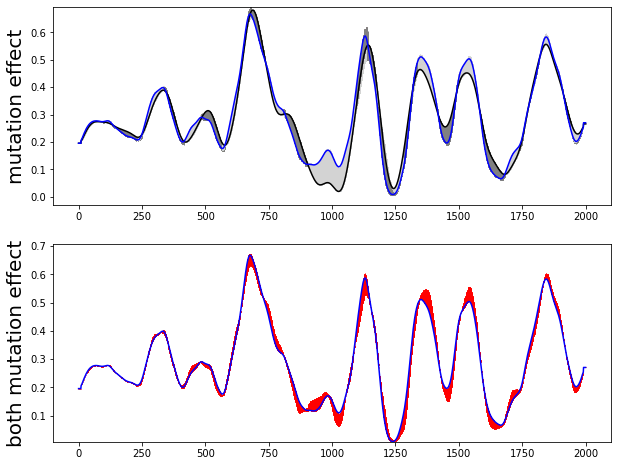

In [175]:
fig = plt.figure(figsize=(10, 8))
start = 0
stop = 2001

ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(start, stop), 
        rolling_mean(y_true),
        color='k',
        label='original')

k = 31
y_true = rolling_mean(y_true)
y_mut1 = rolling_mean(np.mean(mutation_one_pred, axis=1))
y_mut2 = rolling_mean(np.mean(mutation_two_pred[:, k], axis=1))
y_both = rolling_mean(np.mean(mutation_both_pred[:, k], axis=1))
y_max = rolling_mean(compare_array(y_mut1, y_mut2, y_true))

ax.plot(np.arange(start, stop), 
        rolling_mean(y_max),
        color='b',
        label='max_effect')

_true12, _true21, _1true2, _2true1, _12true, _21true = compare_three_array(y_true, y_mut1, y_mut2)

orders = [[0, 1, 2], [0, 2, 1], [1, 0, 2], [2, 0, 1], [1, 2, 0], [2, 1, 0]]
positions = [_true12, _true21, _1true2, _2true1, _12true, _21true]

for position, order in zip(positions, orders):
    if len(position) > 0:
        plot_in_order(position, order, y_true, y_mut1, y_mut2)

ax.set_facecolor('w') 
ax.set_ylabel('mutation effect', fontsize=20)

ax1 = fig.add_subplot(2, 1, 2)

ax1.set_facecolor('w') 
ax1.set_ylabel('both mutation effect', fontsize=20)
#ax1.plot(np.arange(start, stop), 
#         rolling_mean(y_true),
#         color='k',
#         label='original')
ax1.plot(np.arange(start, stop), 
         rolling_mean(y_max),
         color='b',
         label='original')

position = np.where(y_max > y_both)[0]

if len(position) > 0:
    ax1.bar(x=position,
            height=y_max[position] - y_both[position],
            bottom=y_both[position],
            width=1,
            edgecolor='r')

position = np.where(y_max <= y_both)[0]
if len(position) > 0:
    ax1.bar(x=position,
            height=y_both[position] - y_max[position],
            bottom=y_max[position],
            width=1,
            edgecolor='r')

In [152]:
fig.savefig('../Analysis_results/Referee_demand/bimutation_example.eps', format='eps')

### Analysing the effect of multi unimportant mutations

In [159]:
def predict_effect_multi(chrom, idx):
    mutation_position = mutation_down[chrom][idx]
    seq = dna_sequence_around_pos(chrom, mutation_position)
    
    accessible_peaks = mutation_down[chrom][np.arange(idx + 1, idx + 50)]
    peak_to_peak_dist = accessible_peaks - mutation_position
    window = 2001

    y_true = model.predict(one_hot(seq))[:, 0]

    scores = []
    mutation_one_pred = np.zeros((window, 3))
    for i in range(3):
        one_mut_seq = np.copy(seq)
        one_mut_seq[window - 1] = (one_mut_seq[window - 1] + i) % 4 + 1
        mutation_one_pred[:, i] = model.predict(one_hot(one_mut_seq))[:, 0]
        
    score = np.sum([loss(mutation_one_pred[:, i], y_true) for i in range(3)])
    score = (score - means[chrom]) / stds[chrom]
    scores.append(score)
    
    for i in range(1, 51):
        offsets = peak_to_peak_dist[:i]
        mutation_multi_pred = np.zeros((window, 3))
        for i in range(3):
            multi_mut_seq = np.copy(seq)
            multi_mut_seq[window + offsets - 1] = (multi_mut_seq[window + offsets - 1] + i) % 4 + 1
            mutation_multi_pred[:, i] = model.predict(one_hot(multi_mut_seq))[:, 0]
            
        score = np.sum([loss(mutation_multi_pred[:, i], y_true) for i in range(3)])
        score = (score - means[chrom]) / stds[chrom]
    scores.append(score)
    return np.array(scores)

def main():
    matrix_score = np.ones((1, 50))
    for i in range(5, 16):
        chrom = 'chr' + str(i)
        indexes = np.random.randint(1, len(mutation_down[chrom]) - 50, 10)
        
        for idx in indexes:
            scores = predict_effect_multi(chrom, idx).reshape((1, -1))
            matrix_score = np.append(matrix_score, scores, axis=0)
            
        return matrix_score[1:]

#### Visualizing the ConvNet activation

In [ ]:
from keras.models import load_model
from keras import models

In [ ]:
f = h5py.File('./seq_chr_sacCer3/sacCer3/chr16.hdf5',
              'r')
nucleotid = np.array(f['data'])
f.close()
nucleotid = nucleotid[:,0]

X =  (np.arange(4) == nucleotid[...,None]-1).astype(int)
X = X.reshape((X.shape[0], 4))

In [ ]:
X.shape

In [ ]:
model = load_model('../Results_nucleosome/weights_CNN_nucleosome_in_vivo.hdf5',
                   custom_objects={'correlate': correlate,
                                   'mae_cor': mae_cor})

In [ ]:
def plot_activations(nfr_num, nfr_offset):
    xc = 250 - nfr_offset // 4

    start = nfr_position[nfr_num] - 1000 + nfr_offset
    img_tensor = X[start : start + 2001].reshape(1, 2001, 4, 1)
    img_tensor.shape

    activations = activation_model.predict(img_tensor)

    fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)

    axes[0, 0].plot(activations[8][0, :, 0, 0])
    axes[0, 0].axvline(x=xc, color='r', linestyle='--')

    axes[0, 1].plot(activations[8][0, :, 0, 1])
    axes[0, 1].axvline(x=xc, color='r', linestyle='--')

    axes[1, 0].plot(activations[8][0, :, 0, 2])
    axes[1, 0].axvline(x=xc, color='r', linestyle='--')

    axes[1, 1].plot(activations[8][0, :, 0, 3])
    axes[1, 1].axvline(x=xc, color='r', linestyle='--')

    axes[2, 0].plot(activations[8][0, :, 0, 4])
    axes[2, 0].axvline(x=xc, color='r', linestyle='--')

    axes[2, 1].plot(activations[8][0, :, 0, 5])
    axes[2, 1].axvline(x=xc, color='r', linestyle='--')

    axes[3, 0].plot(activations[8][0, :, 0, 6])
    axes[3, 0].axvline(x=xc, color='r', linestyle='--')

    axes[3, 1].plot(activations[8][0, :, 0, 7])
    axes[3, 1].axvline(x=xc, color='r', linestyle='--')

    print(activations[13][0, 0])

In [ ]:
for nfr_offset in np.arange(-1000, 1000, 100):
    plot_activations(10, nfr_offset)

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.arange(start + 1, start + 2000),
        activations[0][0, :, 0, 62])
ax.set_xticks(np.arange(start + 1, start + 2000))
ax.set_xticklabels(nucleotid[start  + 1: start + 2000].astype(int))

In [ ]:
images = np.zeros(64, 3, 1, 4)
kernel_images = np.zeros(64, 3, 4)
a = 0

while a < 64:
    for i in range(4):
        for j in range(4):
            for k in range(4):
                images[a, i, j, k] = 1
    a += 1

kernel_images_weights = np.zeros(64)
    
for i in range(64):
    kernel_weights = model.layers[0].get_weights()[0][:, :, :, i]
    kernel_images_weights[i] = np.
    


#### Experimental p-value

In [ ]:
p_value = np.zeros(counts.shape)
TRIES = 100
N = mutation_peaks.shape[0]
k = -1

for motif, count in zip(motives, counts):
    k += 1
    
    rand_motives = np.array([nucleotid[i - 2 : i + 3] for i in np.random.randint(3, nucleotid.shape[0] - 3, N * TRIES)])
    
    indicators = np.sum(np.abs(rand_motives - motif), axis=1)
    indicators *= -1
    indicators[indicators == 0] = 1
    indicators[indicators < 0] = 0
    
    cumsum = np.cumsum(indicators)
    cumsum = cumsum[N:] - cumsum[: -N]
    
    indexes = [N*i for i in range(TRIES - 1)]
    cumsum = cumsum[indexes]    
    
    p_value[k] = len(np.where(cumsum >= count)[0])

print(p_value)

# Designing a sequence

We design a sequence of 167 bp to use as a nucleosome setter. We select the mutation that help positioning the nucleosome as we want by a Metropolis algorithm.

In [ ]:
seq = np.load('../Results_nucleosome/designed_sequence.npy')
x_seq = process(seq)

model = load_model('../Results_nucleosome/weights_collaborator_WT_167_rep1.hdf5',
                  custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})

In [ ]:
y_syn = model.predict(x_seq)
plt.plot(y_syn)